## 1- Connecter Google Drive avec l'environnement pour utiliser la base de données

In [4]:
from google.colab import drive
drive.mount('/content/drive/')
data_url = "/content/drive/MyDrive/Potato/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 2- Charger les modules et les packages nécessaires 

In [5]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow

## 3- Préparation des données 
### 3-1- Augmentation des données


In [7]:
datagen_train = ImageDataGenerator(
    rescale=1.0/255.0, 
    width_shift_range=0.1, 
    rotation_range = 10,
    brightness_range=(0.5, 1),
    fill_mode='reflect',
    horizontal_flip=True,  
    vertical_flip=True,
    )

datagen_valid = ImageDataGenerator(
    rescale=1.0/255.0,
)

### 3-2- Base du données

In [8]:
training = datagen_train.flow_from_directory(data_url + "Train",
    color_mode="rgb",
    class_mode = 'categorical',
    target_size=(224, 224),
    batch_size=8,
    )

valid = datagen_valid.flow_from_directory(data_url + "Valid",
    color_mode="rgb",
    class_mode = 'categorical',
    target_size=(224, 224),
    batch_size=8,
    )

Found 910 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


## 4- Chargement du model VGG16

In [9]:
base_model = keras.applications.VGG16(
    weights='imagenet', 
    input_shape=(224, 224, 3),
    include_top=False)
base_model.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 5- Ajouter l'entrée et la sortie 

In [18]:
input = keras.Input(shape=(224,224,3))
x = base_model(input , training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(3)(x)
blight_detector = keras.Model(input , output)

In [19]:
blight_detector.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
blight_detector.compile(
    optimizer= keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics
    =[keras.metrics.CategoricalAccuracy()])

## 6- Apprentissage de la dernière couche 

In [24]:
blight_detector.fit(training, steps_per_epoch=12, validation_data=valid, validation_steps=4, epochs=20)
blight_detector.save('/content/drive/MyDrive/model_v2')

Epoch 1/20
12/12 [==============================] - 2s 172ms/step - loss: 0.5622 - categorical_accuracy: 0.8438 - val_loss: 0.5183 - val_categorical_accuracy: 0.8438
Epoch 2/20
12/12 [==============================] - 2s 163ms/step - loss: 0.5443 - categorical_accuracy: 0.8542 - val_loss: 0.4334 - val_categorical_accuracy: 0.9688
Epoch 3/20
12/12 [==============================] - 2s 167ms/step - loss: 0.5006 - categorical_accuracy: 0.8542 - val_loss: 0.4735 - val_categorical_accuracy: 0.8750
Epoch 4/20
12/12 [==============================] - 2s 164ms/step - loss: 0.5407 - categorical_accuracy: 0.8125 - val_loss: 0.5615 - val_categorical_accuracy: 0.6875
Epoch 5/20
12/12 [==============================] - 2s 186ms/step - loss: 0.5447 - categorical_accuracy: 0.8125 - val_loss: 0.4647 - val_categorical_accuracy: 0.9375
Epoch 6/20
12/12 [==============================] - 2s 160ms/step - loss: 0.5179 - categorical_accuracy: 0.8723 - val_loss: 0.4460 - val_categorical_accuracy: 0.8750
Epoc

## 7- Fine Tuning

In [25]:
base_model.trainable = True
blight_detector.compile(optimizer=keras.optimizers.Adam(learning_rate = .00001),  
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])
blight_detector.fit(training, steps_per_epoch=12, validation_data=valid, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 6s 214ms/step - loss: 0.4454 - categorical_accuracy: 0.8646 - val_loss: 0.3729 - val_categorical_accuracy: 0.9062
Epoch 2/20
12/12 [==============================] - 2s 195ms/step - loss: 0.4599 - categorical_accuracy: 0.8125 - val_loss: 0.2131 - val_categorical_accuracy: 0.9688
Epoch 3/20
12/12 [==============================] - 2s 196ms/step - loss: 0.3951 - categorical_accuracy: 0.8542 - val_loss: 0.4136 - val_categorical_accuracy: 0.8125
Epoch 4/20
12/12 [==============================] - 2s 195ms/step - loss: 0.2811 - categorical_accuracy: 0.8750 - val_loss: 0.2369 - val_categorical_accuracy: 0.8750
Epoch 5/20
12/12 [==============================] - 2s 197ms/step - loss: 0.2424 - categorical_accuracy: 0.8958 - val_loss: 0.1660 - val_categorical_accuracy: 0.9062
Epoch 6/20
12/12 [==============================] - 4s 320ms/step - loss: 0.1649 - categorical_accuracy: 0.9574 - val_loss: 0.1899 - val_categorical_accuracy: 0.9062
Epoc

In [26]:
blight_detector.save('/content/drive/MyDrive/model_v2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_v2/assets


## 8- Résultats

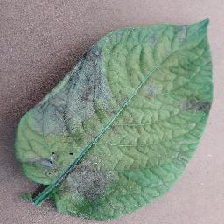

Late blight


In [37]:
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import preprocess_input
image_path = '/content/drive/MyDrive/Potato/Test/Potato___Late_blight/24482fe2-5139-4f73-909e-9ea4a3d8bf5d___RS_LB 4733.JPG'
image = image_utils.load_img(image_path, target_size=(224, 224))
image = image_utils.img_to_array(image)
cv2_imshow(image)
image = image.reshape(1,224,224,3)
preds = blight_detector.predict(image/255)
if (preds[0][0] > 0) :
  print('Early blight')
elif preds[0][1] > 0 :
  print('Late blight')
else :
  print('healthy')